In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nrrd
import pandas as pd
import os
import sys

# sys.path.append("/mnt/raid/C1_ML_Analysis/source/autoencoder/src")
sys.path.append("/mnt/raid/C1_ML_Analysis/source/blender/famli-ultra-sim/dl/")
sys.path.append("/mnt/raid/C1_ML_Analysis/source/blender/famli-ultra-sim/dl/nets")

from nets import diffusion, spade, lotus, cut
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet, AutoencoderKL, VQVAE, PatchDiscriminator, MultiScalePatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

import monai
from monai.transforms import (    
    Compose,    
    RandFlip,
    RandRotate,
    CenterSpatialCrop,
    ScaleIntensityRange,
    RandAdjustContrast,
    RandGaussianNoise,
    RandGaussianSmooth
)

from loaders.ultrasound_dataset import USDatasetV2, LotusDataset
from transforms.ultrasound_transforms import LotusEvalTransforms, LotusTrainTransforms, RealUSTrainTransformsV2, RealUSEvalTransformsV2
from torchvision import transforms

In [2]:
mount_point = '/mnt/raid/C1_ML_Analysis'
df = pd.read_parquet(os.path.join(mount_point, "CSV_files", "extract_frames_blind_sweeps_c1_30082022_wscores_test_w16_kmeans_sample_train.parquet"))
df = df.query('score > 0.999').reset_index(drop=True)

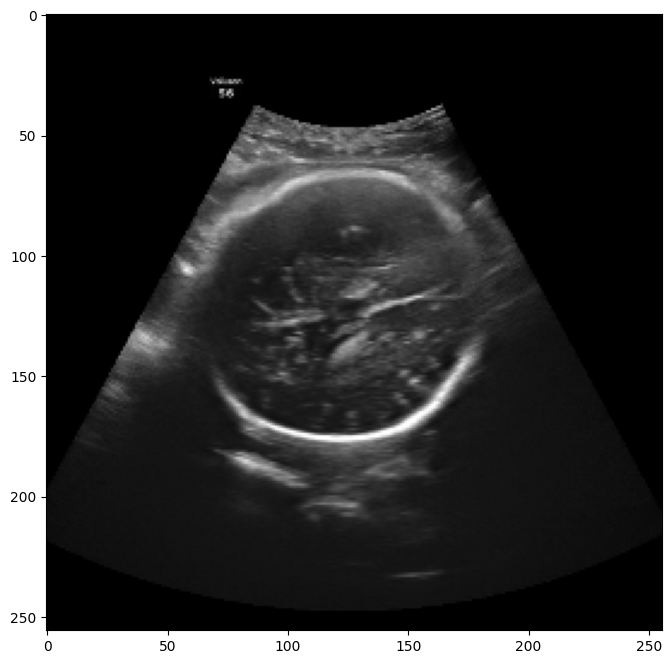

In [3]:
mpl.rcParams['figure.figsize'] = (12, 8)

img_np, head = nrrd.read(os.path.join(mount_point, df['img_path'][0]), index_order="C")

img = torch.FloatTensor(img_np/255)

def input_T(input):
    # [0,1] -> [-1,+1]
    return 2*input-1
    
def output_T(input):
    # [-1,+1] -> [0,1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0,1), cmap='gray')
    
img_=input_T(img)
show(img_)


In [4]:
#Defining the schedule for the diffusion process
num_timesteps=1000
betas=torch.linspace(1e-4,2e-2,num_timesteps)

alphas=1-betas
alphas_sqrt=alphas.sqrt()
alphas_cumprod=torch.cumprod(alphas,0)
alphas_cumprod_sqrt=alphas_cumprod.sqrt()

In [5]:
def forward_step(t, condition_img, return_noise=False):
    """
        forward step: t-1 -> t
    """    
    assert t >= 0

    mean=alphas_sqrt[t]*condition_img    
    std=betas[t].sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise
    
def forward_jump(t, condition_img, condition_idx=0, return_noise=False):
    """
        forward jump: 0 -> t
    """   
    assert t >= 0
    
    mean=alphas_cumprod_sqrt[t]*condition_img
    std=(1-alphas_cumprod[t]).sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

In [6]:
N=5 # number of computed states between x_0 and x_T
M=4 # number of samples taken from each distribution

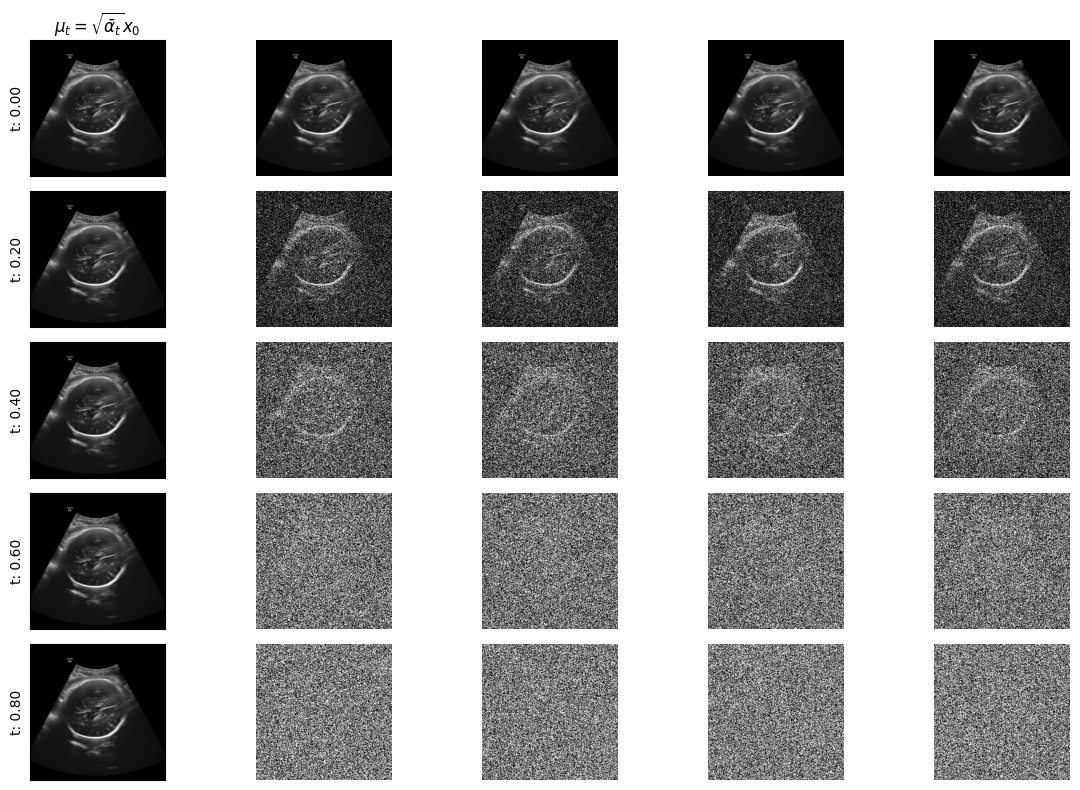

In [7]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_cumprod_sqrt[t_step]*img_)
    plt.title(r'$\mu_t=\sqrt{\bar{\alpha}_t}x_0$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        x_t=forward_jump(t_step,img_)
        
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        show(x_t)        
        plt.axis('off')
        
plt.tight_layout()

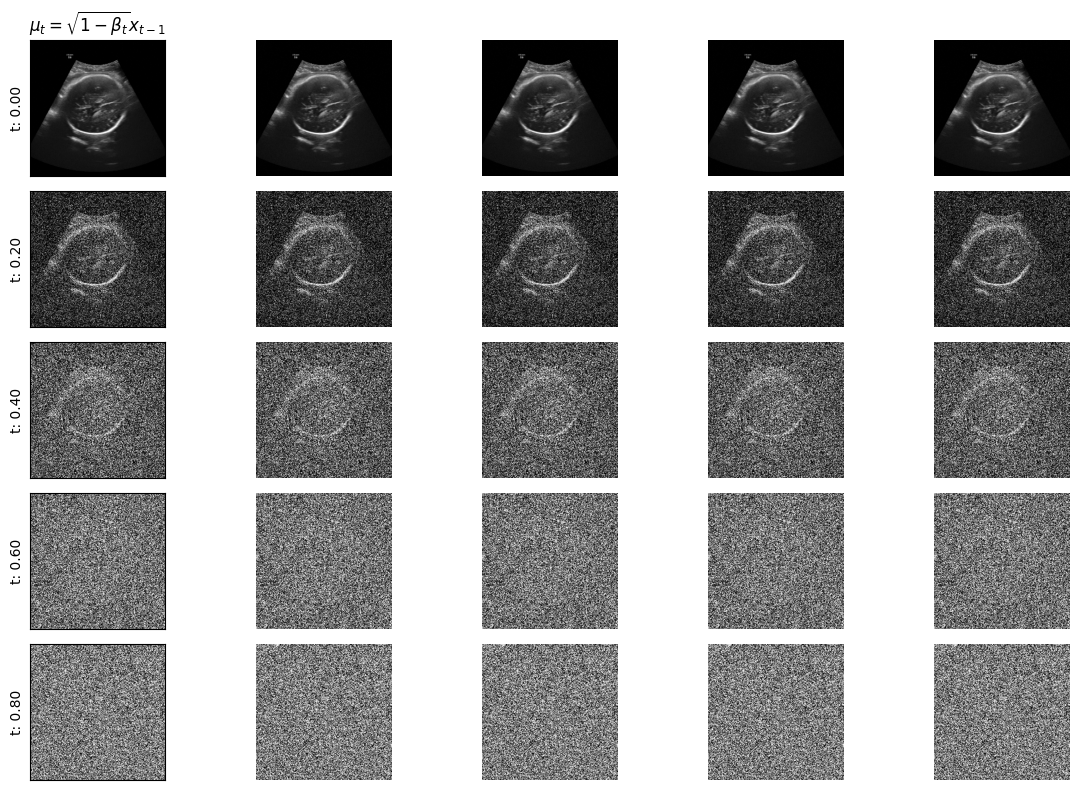

In [8]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    prev_img=forward_jump(max([0,t_step-1]),img_) # directly go to prev state
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_sqrt[t_step]*prev_img)
    plt.title(r'$\mu_t=\sqrt{1-\beta_t}x_{t-1}$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        x_t=forward_step(t_step,prev_img)
        show(x_t)        
        plt.axis('off')
plt.tight_layout()

(-0.5, 255.5, 255.5, -0.5)

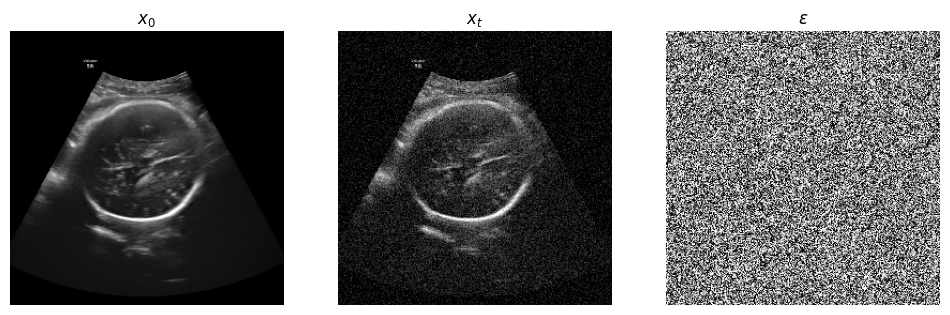

In [9]:
t_step=50

x_t,noise=forward_jump(t_step,img_,return_noise=True)

plt.subplot(1,3,1)
show(img_)
plt.title(r'$x_0$')
plt.axis('off')
plt.subplot(1,3,2)
show(x_t)
plt.title(r'$x_t$')
plt.axis('off')
plt.subplot(1,3,3)
show(noise)
plt.title(r'$\epsilon$')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

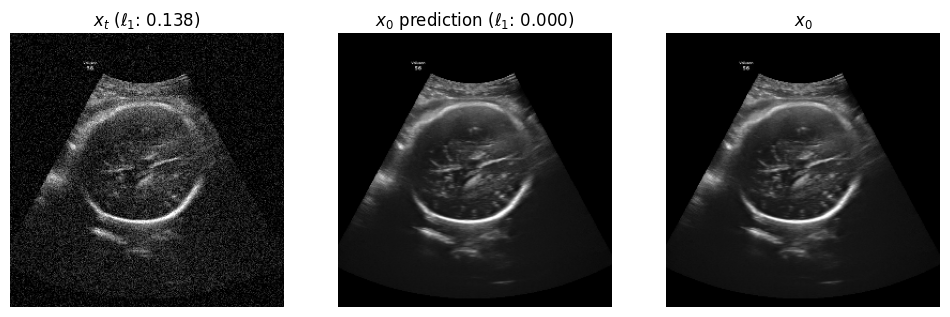

In [10]:
x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*noise)/(alphas_cumprod_sqrt[t_step])

plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$ ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.axis('off')
plt.subplot(1,3,2)
show(x_0_pred)
plt.title('$x_0$ prediction ($\ell_1$: {:.3f})'.format(F.l1_loss(x_0_pred,img_)))
plt.axis('off') 
plt.subplot(1,3,3)
show(img_)
plt.title('$x_0$')
plt.axis('off')

In [11]:
# estimate mean
mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

# let's compare it to ground truth mean of the previous step (requires knowledge of x_0)
mean_gt=alphas_cumprod_sqrt[t_step-1]*img_

Text(0.5, 1.0, '$\\mu_{t-1}$  ($\\ell_1$: 0.012)')

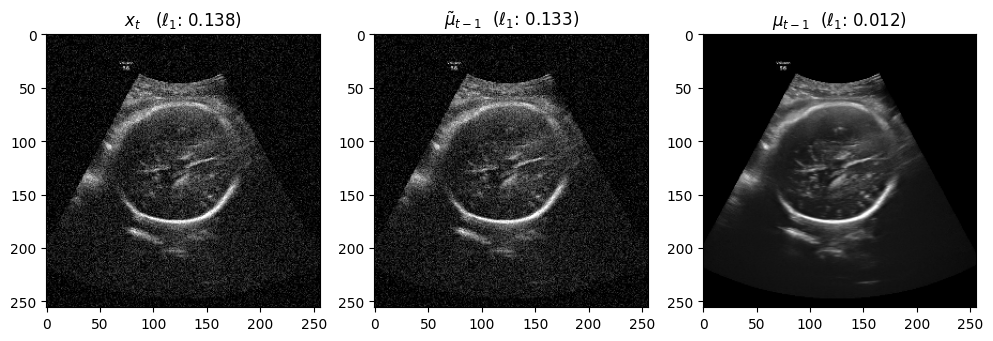

In [12]:
plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$   ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.subplot(1,3,2)
show(mean_pred)
plt.title(r'$\tilde{\mu}_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_pred,img_)))
plt.subplot(1,3,3)
show(mean_gt)
plt.title(r'$\mu_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_gt,img_)))

In [13]:
def reverse_step(epsilon, x_t, t_step, return_noise=False):
    
    # estimate x_0 based on epsilon
    x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*epsilon)/(alphas_cumprod_sqrt[t_step])
    if t_step==0:
        sample=x_0_pred
        noise=torch.zeros_like(x_0_pred)
    else:
        # estimate mean
        mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

        # compute variance
        beta_pred=betas[t_step].sqrt() if t_step != 0 else 0

        sample=mean_pred+beta_pred*torch.randn_like(x_t)
        # this noise is only computed for simulation purposes (since x_0_pred is not known normally)
        noise=(sample-x_0_pred*alphas_cumprod_sqrt[t_step-1])/(1-alphas_cumprod[t_step-1]).sqrt()
    if return_noise:
        return sample, noise
    else:
        return sample

In [14]:
model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_Dataset_C_masked_resampled_256_spc075_wscores_meta_BPD01_MACFL025-7mo-9mo/v0.1/last.ckpt"

NN = getattr(diffusion, "DDPMPL")
model = NN.load_from_checkpoint(model_fn)
model.eval()
model.cuda()

Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../raid/C1_ML_Analysis/train_output/diffusion/extract_frames_Dataset_C_masked_resampled_256_spc075_wscores_meta_BPD01_MACFL025-7mo-9mo/v0.1/last.ckpt`


DDPMPL(
  (model): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection): I

In [15]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
inferer = DiffusionInferer(scheduler=scheduler)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.33it/s]


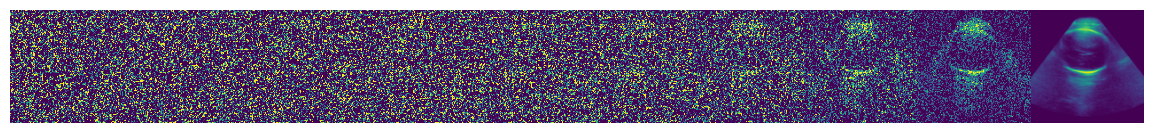

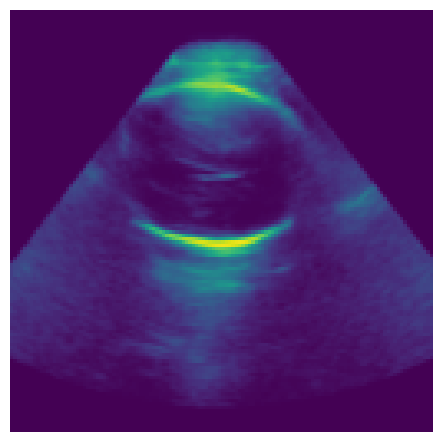

In [16]:
noise = torch.randn((1, 1, 128, 128))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [17]:
# USDatasetV2(self.df_test, self.mount_point, img_column=self.img_column, class_column=self.class_column, ga_column=self.ga_column, scalar_column=self.scalar_column, transform=self.test_transform)

model_fn = '/mnt/raid/C1_ML_Analysis/train_output/ultra-sim/rendering_spade_linear/v0.2/epoch=5-val_loss=6.72.ckpt'

model_sp = spade.SPADELotus.load_from_checkpoint(model_fn)
model_sp.eval()
model_sp.cuda()

df_test = pd.read_csv('/mnt/raid/C1_ML_Analysis/source/blender/simulated_data_export/CSV_files/label_diffusor_v2_test.csv')
mount_point = '/mnt/raid/C1_ML_Analysis/source/blender/simulated_data_export' 

test_ds = monai.data.Dataset(data=LotusDataset(df_test, mount_point), transform=LotusEvalTransforms())

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../raid/C1_ML_Analysis/train_output/ultra-sim/rendering_spade_linear/v0.2/epoch=5-val_loss=6.72.ckpt`
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warning

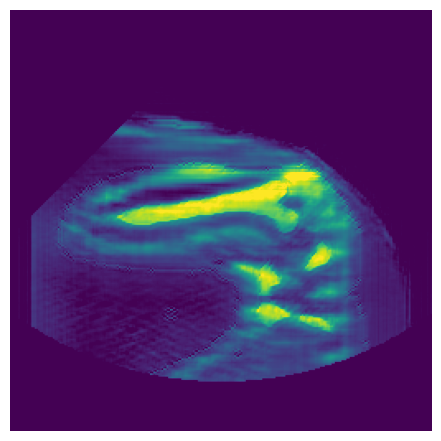

In [20]:
sp_out = model_sp(test_ds[0]['seg'][None,:].cuda())[0]
plt.style.use("default")
plt.imshow(sp_out[0].permute(1,2,0).detach().cpu().numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.62it/s]


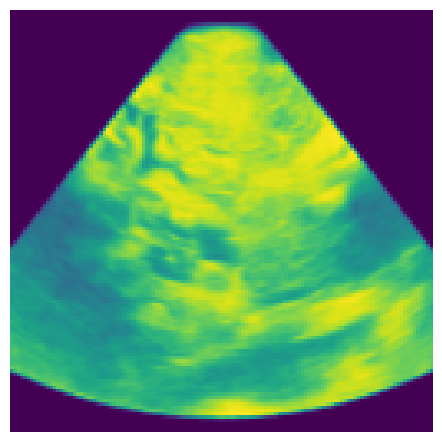

In [21]:




# noise = torch.randn((1, 1, 128, 128))
# noise = noise.cuda()
noise = transforms.Resize(128)(sp_out)
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=5
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

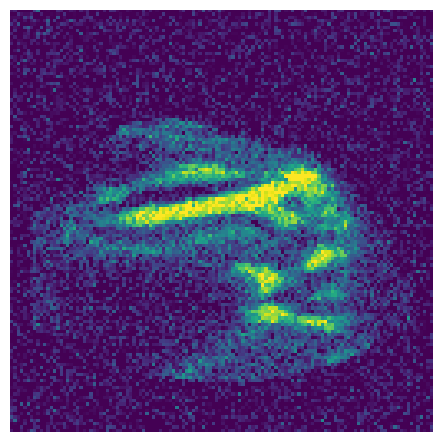

In [22]:
noise = torch.randn((1, 1, 128, 128))
noise = noise.cuda()
noisy_image = scheduler.add_noise(original_samples=transforms.Resize(128)(sp_out), noise=noise, timesteps=torch.tensor(30))
plt.style.use("default")
plt.imshow(noisy_image[0].cpu().detach().permute(1,2,0).numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.16it/s]


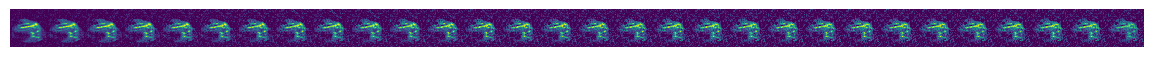

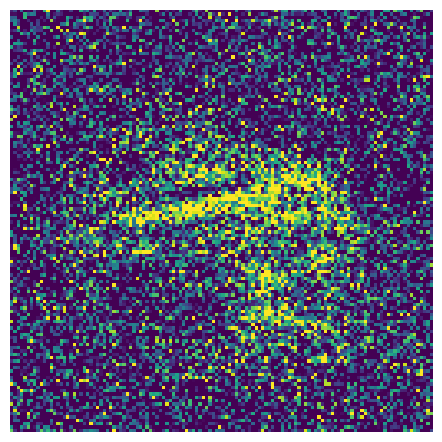

In [23]:
# noise = transforms.Resize(128)(sp_out)
scheduler.set_timesteps(num_inference_steps=30)


image, intermediates = inferer.sample(
    input_noise=noisy_image, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=1
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [24]:
from torchvision.transforms import v2
# torchvision.transforms.v2.RandomErasing

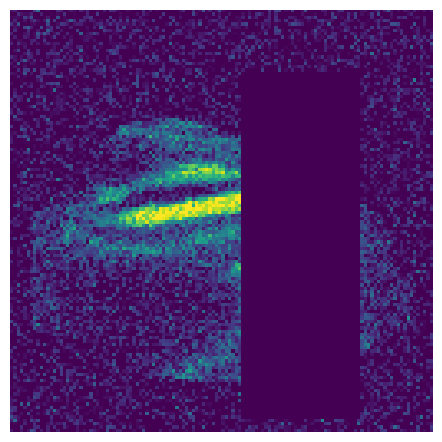

In [25]:
img_erase = v2.RandomErasing()(noisy_image)
plt.style.use("default")
plt.imshow(img_erase[0].cpu().detach().permute(1,2,0).numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [26]:
# model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_Dataset_C_masked_resampled_256_spc075_wscores_meta_BPDACFLL1MR0C1-7mo-9mo/v0.1/last.ckpt"
model_fn = '/mnt/raid/C1_ML_Analysis/train_output/diffusionAE/extract_frames_Dataset_C_masked_resampled_256_spc075_wscores_meta_BPD01_MACFL025-7mo-9mo/v0.4/epoch=72-val_loss=0.01.ckpt'
model_ae = diffusion.AutoEncoderKL.load_from_checkpoint(model_fn)
model_ae.cuda()
model_ae.eval()

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AutoEncoderKL(
  (autoencoderkl): AutoencoderKL(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): Convolution(
          (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (nin_shortcut): Identity()
        )
        (2): Downsample(
          (conv): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
        (3): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 256, kernel_size=(3, 3

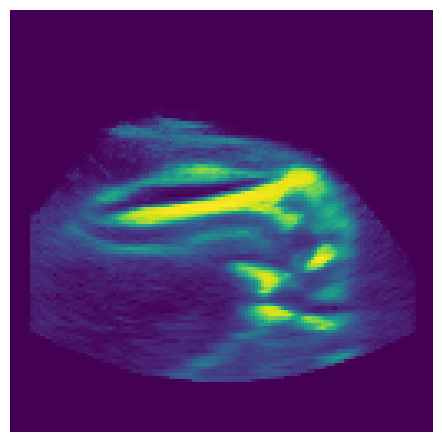

In [27]:
plt.style.use("default")
plt.imshow(model_ae(transforms.Resize(128)(sp_out.cuda()))[0][0].cpu().detach().permute(1,2,0).numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [28]:
model_ae.autoencoderkl.encoder(transforms.Resize(128)(sp_out.cuda())).shape

torch.Size([1, 3, 32, 32])

In [29]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    num_channels=8,
    in_channels=1,
    out_channels=8,
    minimum_size_im=256,
    norm="INSTANCE",
    kernel_size=3,
)

In [30]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat):
    criterion = torch.nn.L1Loss()
    num_D = len(input_features_disc_fake)
    GAN_Feat_loss = torch.zeros(1)
    for i in range(num_D):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            GAN_Feat_loss += unweighted_loss * lambda_feat / num_D
    return GAN_Feat_loss

In [31]:
fake = torch.rand(1, 1, 256, 256)
disc_fakes, features_fakes = discriminator(fake)
# loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)

real = torch.rand(1, 1, 256, 256)
disc_reals, features_reals = discriminator(real)
loss_feat = feature_loss(features_fakes, features_reals, lambda_feat=0.1)


In [32]:
#for discriminator

# disc_fakes, _ = discriminator(torch.cat([out, label], 1))
# loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
# loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
# optimizer_D.zero_grad()
# loss_d = loss_d_r + loss_g_f
# loss_d.backward()

In [33]:
torch.argsort(1 - torch.tensor([-1, 0, 1, 0.1]))

tensor([2, 3, 1, 0])

In [34]:
model_fn = '/mnt/raid/C1_ML_Analysis/train_output/ultra-sim/rendering_cut_linear/v0.2/epoch=39-val_loss=3.66.ckpt'

model_cu = cut.CutLinear.load_from_checkpoint(model_fn)
model_cu.eval()
model_cu.cuda()

CutLinear(
  (D_Y): Discriminator(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Downsample(
        (model): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Downsample(
        (model): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): LeakyReLU(negative_slope=0.2, 

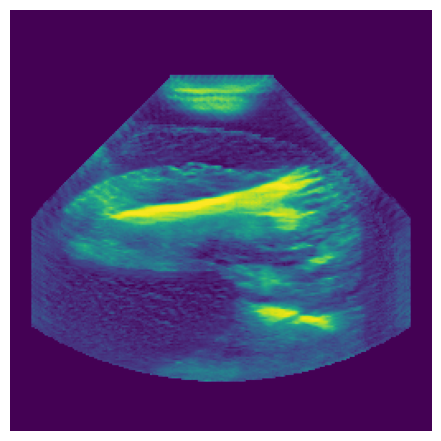

In [35]:
sp_out = model_cu(test_ds[0]['seg'][None,:].cuda())
plt.style.use("default")
plt.imshow(sp_out[0].permute(1,2,0).detach().cpu().numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

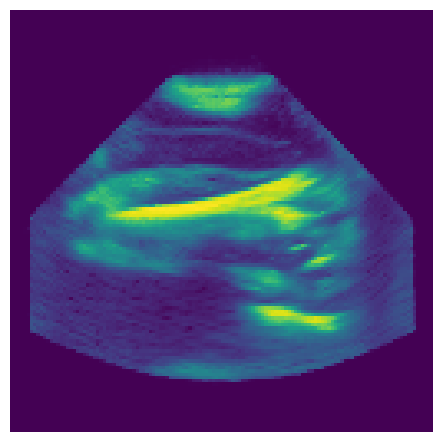

In [36]:
plt.style.use("default")
plt.imshow(model_ae(transforms.Resize(128)(sp_out.cuda()))[0][0].cpu().detach().permute(1,2,0).numpy(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()